# Libraries + DATA

In [1]:
from visualizations import *
import numpy as np
import pandas as pd
import warnings
from math import tau
import matplotlib.pyplot as plt
from scipy.integrate import quad
warnings.filterwarnings('ignore')

In [2]:
data = np.loadtxt("./../DATA/digits2k_pixels.data.gz", ndmin=2)/255.0
data.shape = (data.shape[0], int(np.sqrt(data.shape[1])), int(np.sqrt(data.shape[1])))
labels = np.loadtxt("./../DATA/digits2k_pixels.labels.gz", dtype='int')

# Helpful functions

In [3]:
def onlyBlackWhite(array, percentage = 0.3):
    result = array.copy()
    quantile = np.quantile(result[result>0], percentage)
    for i in range(len(result)):
        for j in range(len(result[0])):
            if (result[i,j] < quantile):
                result[i,j] = 0
            else:
                result[i,j] = 1
    return result
## By using quantiles, we reduce some noise near the number and away from the number
## Empiric tests show that 0.3 quantile produces some nice results

In [4]:
def get_longest_array(arr_list):
    n = len(arr_list)
    max_len = 0
    max_i = 0
    for i in range(n):
        if len(arr_list[i]) > max_len:
            max_len, max_i = len(arr_list[i]), i
    return max_i

In [5]:
def create_close_loop(image_array, level=[200]):

    # Get Contour Path and create lookup-table
    contour_paths = plt.contour(image_array, levels=level, colors='black', origin='image').collections[0].get_paths()
    contour_path = contour_paths[get_longest_array(contour_paths)]
    x_table, y_table = contour_path.vertices[:, 0], contour_path.vertices[:, 1]
    time_table = np.linspace(0, tau, len(x_table))

    # Simple method to center the image
    x_table = x_table - min(x_table)
    y_table = y_table - min(y_table)
    x_table = x_table - max(x_table) / 2
    y_table = y_table - max(y_table) / 2

    return time_table, x_table, y_table

### Some fourier series generating functions (explained in other scripts)

In [6]:
def f(t, time_table, x_table, y_table):
    return interp(t, time_table, x_table) + 1j*interp(t, time_table, y_table)

def coef_list(time_table, x_table, y_table, order=10):
    """
    Counting c_n coefficients of Fourier series, of function aproximated by points (time_table, x_table + j*y_table)
    of order of magnitude = order
    """
    coef_list = []
    for n in range(-order, order+1):
        real_coef = quad(lambda t: np.real(f(t, time_table, x_table, y_table) * np.exp(-n*1j*t)), 0, tau, limit=100, full_output=1)[0]/tau
        imag_coef = quad(lambda t: np.imag(f(t, time_table, x_table, y_table) * np.exp(-n*1j*t)), 0, tau, limit=100, full_output=1)[0]/tau
        coef_list.append([real_coef, imag_coef])
    return np.array(coef_list)

# Generating

This time, we will use Fourier series, not to get coefficients in the result, but first points of the Fourier Shape Description, then their distances from the centroids

#### Now we also need functions for: interpolation of n points from fourier series, finding radiuses of centroid distances of these points.

In [7]:
def DFT(t, coef_list, order=10):
    """
    get points of Fourier series aproximation, where t is a time argument for which we want to get (from range[0, tau])
    """
    kernel = np.array([np.exp(-n*1j*t) for n in range(-order, order+1)])
    series = np.sum( (coef_list[:,0]+1j*coef_list[:,1]) * kernel[:])
    return np.real(series), np.imag(series)

In [8]:
def GenerateShapePoints(coef_list, n=100):
    time_space = np.linspace(0, tau, n)
    x_DFT = [DFT(t, coef)[0] for t in time_space]
    y_DFT = [DFT(t, coef)[1] for t in time_space]
    return x_DFT, y_DFT

##### Test

In [9]:
copied = onlyBlackWhite(data[i,:,:])
time_table, x_table, y_table = create_close_loop(copied)
coef = coef_list(time_table, x_table, y_table, order=10)
X, Y = GenerateShapePoints(coef, n=30)
plt.plot(X, Y, '-o')
## n = 30 describes the number well enough (we still want to do it in reasonable time)

NameError: name 'i' is not defined

### Now a function generating centroid distances

Maybe here is a good moment to explain why we use this method. According to https://cis.temple.edu/~lakamper/courses/cis9601_2009/etc/fourierShape.pdf it simply gives best results when comparing shapes using Fourier transformations. It's a really well written article on the topic, I strongly reccomened getting some insights.

In [10]:
import math

In [14]:
def measureDistancesFromCentroids(coef_list, N=30):
    X, Y = GenerateShapePoints(coef_list, n=N)
    x_centroid = np.mean(X)
    y_centroid = np.mean(Y)
    centr_r = []
    
    for i in range(N):
        x_dist_sq = (X[i] - x_centroid)**2
        y_dist_sq = (Y[i] - y_centroid)**2
        centr_r.append(math.sqrt(x_dist_sq + y_dist_sq))
    
    return np.array(centr_r)

## Let's proceed to actual generating

In [15]:
i_gen = np.linspace(0, len(data)-1, len(data)).astype(int)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


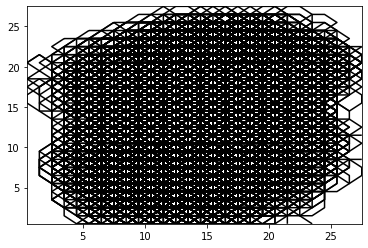

In [16]:
centr_radiuses = []
for i in i_gen:
    copied = onlyBlackWhite(data[i,:,:])
    time_table, x_table, y_table = create_close_loop(copied)
    coef = coef_list(time_table, x_table, y_table, order=10)
    centr_radiuses.append(measureDistancesFromCentroids(coef, N=50))
    if i%100 == 0:
        print(i)

np.save(file='centroid_distances_N_50', arr=centr_radiuses)

GOT IT!